# Libraries

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import importlib.metadata
import numpy as np
import seaborn as sns
import shap
import lime
import lime.lime_tabular

from sklearn.model_selection import train_test_split, RandomizedSearchCV, cross_val_score, GridSearchCV
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler, OneHotEncoder
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.linear_model import ElasticNet

from scipy.stats import randint, uniform

from my_functions import clean_dataframe, trim_outliers

In [2]:
!python --version

Python 3.11.5


In [3]:
# Version des bibliothèques utilisées
print('\n'.join(f'{m.__name__} - {m.__version__}' 
                for m in globals().values() 
                if getattr(m, '__version__', None)))

print("matplotlib - ", importlib.metadata.version('matplotlib'))

pandas - 2.0.3
numpy - 1.24.3
seaborn - 0.12.2
shap - 0.44.1
matplotlib -  3.7.2


# Préliminaires

In [4]:
pd.set_option('display.max_columns', None)

In [5]:
def data_prep(df, target='SiteEnergyUseWN_ln', test_size=0.3, random_state=42, scaler_type='minmax'):
    
    
    """
    Cette fonction prend un dataframe en argument. Elle construit X (colonnes des valeurs) et y (colonne cible).
    Elle split les données en train/test.
    Elle scale les données numériques (pas les pourcentages).
    Elle one-hot encode les données non numériques.
    Pour les données non numériques pour lesquelles on dispose d'un pourcentage, elle multiplie les valeurs de l'encoding par
    ce pourcentage (au lieu d'avoir des 0 et des 1, on aura des 0 et des pourcentages).
    
    Arguments :
    df : dataframe sur lequel on travaille
    target : la variable que l'on cherchera à prédire. Par défaut "SiteEnergyUseWN_ln". On peut aussi avoir "TotalGHGEmissions_ln".
    test_size : proportion du dataframe dédié au test
    random_state : random_state
    scaler_type : type de scaler. Par défaut, MinMaxScaler. 
                                  Pour StandardScaler : scaler_type='standard'
                                  Pour RobustScaler : scaler_type='robust'
                                        
    """
    
    
    # Création de X et y
    X = df.drop(columns=['SiteEnergyUseWN_ln', 'TotalGHGEmissions_ln'])
    y = df[target]

    
    """
    SPLITTING
    """
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)

    
    """
    SCALING
    """

    numerical_cols = X_train.select_dtypes(include=['float64', 'int64']).columns
    numerical_cols = [col for col in numerical_cols if '(%)' not in col]  # Exclude columns with '(%)' in their names
    
    if scaler_type == 'standard':
        scaler = StandardScaler()
    elif scaler_type == 'minmax':
        scaler = MinMaxScaler()
    elif scaler_type == 'robust':
        scaler = RobustScaler()

    X_train[numerical_cols] = scaler.fit_transform(X_train[numerical_cols])
    X_test[numerical_cols] = scaler.transform(X_test[numerical_cols])

    
    """
    ENCODING
    """
    
    # One-hot encoding des variables non numériques
    categorical_cols = X_train.select_dtypes(include=['object']).columns
    encoder = OneHotEncoder(categories='auto', handle_unknown='ignore', sparse_output=False, dtype=int)  

    # Fit transform sur X_train
    X_train_encoded = pd.DataFrame(encoder.fit_transform(X_train[categorical_cols]))
    X_train_encoded.columns = encoder.get_feature_names_out(categorical_cols)

    # Fit transform sur X_test
    X_test_encoded = pd.DataFrame(encoder.transform(X_test[categorical_cols]))
    X_test_encoded.columns = encoder.get_feature_names_out(categorical_cols)

    # on garde les indices originaux
    X_train_encoded.index = X_train.index
    X_test_encoded.index = X_test.index

    # Suppression des colonnes originales
    X_train.drop(columns=categorical_cols, inplace=True)
    X_test.drop(columns=categorical_cols, inplace=True)

    # Concatenation des colonnes encodées
    X_train = pd.concat([X_train, X_train_encoded], axis=1)
    X_test = pd.concat([X_test, X_test_encoded], axis=1)

    
    """
    MULTIPLICATION DES POURCENTAGES
    """

    property_types = ['LargestPropertyUseType', 'SecondLargestPropertyUseType', 'ThirdLargestPropertyUseType']

    for prop_type in property_types:
        # on prend les colonnes dont le nom commence par la clef
        encoded_property_cols_train = X_train.loc[:, X_train.columns.str.startswith(f'{prop_type}_')]
        encoded_property_cols_test = X_test.loc[:, X_test.columns.str.startswith(f'{prop_type}_')]

        # on sort le pourcentage correspondant dans X_train
        percentage_col_train = f'{prop_type}(%)'
        percentage_values_train = X_train[percentage_col_train]

        # on multiplie
        for col in encoded_property_cols_train.columns:
            X_train[col] *= percentage_values_train

        # Suppression de la colonne de pourcentages dans X_train
        X_train.drop(columns=percentage_col_train, inplace=True)

        # on sort le pourcentage correspondant dans X_test
        percentage_col_test = f'{prop_type}(%)'
        percentage_values_test = X_test[percentage_col_test]

        # on multiplie
        for col in encoded_property_cols_test.columns:
            X_test[col] *= percentage_values_test

        # Suppression de la colonne de pourcentages dans X_test
        X_test.drop(columns=percentage_col_test, inplace=True)

    return X_train, X_test, y_train, y_test, target

# Dataframe de résultats

In [6]:
results = pd.DataFrame(columns=['Algo', 'Model Name', 'Outliers', 'EnergyScore', 'Target', 'Hyperparams', 'R-squared Train', 'R-squared', 'MAE', 'RMSE', 'CV Mean RMSE', 'Train Rows'])

#  1. Dummy Regressor

In [7]:
from sklearn.dummy import DummyRegressor

## No Energy Score, with Outliers

In [8]:
df = pd.read_csv('df_score_out.csv')
df.set_index('OSEBuildingID', inplace=True)

In [9]:
X_train, X_test, y_train, y_test, target = data_prep(df, target='TotalGHGEmissions_ln', test_size=0.3, random_state=42, scaler_type='robust')

In [10]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

dummy_regressor = DummyRegressor()
model_name = 'dummy_regressor'

dummy_regressor.fit(X_train, y_train) # on fit

y_pred = dummy_regressor.predict(X_test)
y_train_pred = dummy_regressor.predict(X_train)# on prédit

# Résultats
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)
r_squared = r2_score(y_test, y_pred)
r_squared_train = r2_score(y_train, y_train_pred)

print("Dummy Regressor Metrics:")
print("Mean Squared Error:", mse)
print("Mean Absolute Error:", mae)
print("R-squared Score:", r_squared)
print("Training Set - R-squared Score:", r_squared_train)

Dummy Regressor Metrics:
Mean Squared Error: 2.234268398926195
Mean Absolute Error: 1.1995330514113216
R-squared Score: -0.004092586668094755
Training Set - R-squared Score: 0.0


In [11]:
results = pd.concat([results, pd.DataFrame({'Algo': ['DummyRegressor'],
                                            'Model Name': [model_name],
                                            'Outliers': ['With'],
                                            'EnergyScore': ['With'],
                                            'Target': [target],
                                            'Hyperparams': ['Mean'],
                                            'R-squared Train': [r_squared_train],
                                            'R-squared': [r_squared],
                                            'MAE': [mae],
                                            'RMSE': [rmse], 
                                            'Train Rows': [X_train.shape[0]] })], ignore_index=True)

## No Energy Score, without Outliers

In [12]:
df = pd.read_csv('df_score_noout.csv')
df.set_index('OSEBuildingID', inplace=True)

In [13]:
X_train, X_test, y_train, y_test, target = data_prep(df, target='TotalGHGEmissions_ln', test_size=0.3, random_state=42, scaler_type='robust')

In [14]:
dummy_regressor = DummyRegressor()
model_name = 'dummy_regressor'

dummy_regressor.fit(X_train, y_train) # on fit

y_pred = dummy_regressor.predict(X_test)
y_train_pred = dummy_regressor.predict(X_train)# on prédit

# Résultats
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)
r_squared = r2_score(y_test, y_pred)
r_squared_train = r2_score(y_train, y_train_pred)

print("Dummy Regressor Metrics:")
print("Mean Squared Error:", mse)
print("Mean Absolute Error:", mae)
print("R-squared Score:", r_squared)
print("Training Set - R-squared Score:", r_squared_train)

Dummy Regressor Metrics:
Mean Squared Error: 1.9612007304905605
Mean Absolute Error: 1.1174636146131331
R-squared Score: -0.019343425693404193
Training Set - R-squared Score: 0.0


In [15]:
results = pd.concat([results, pd.DataFrame({'Algo': ['DummyRegressor'],
                                            'Model Name': [model_name],
                                            'Outliers': ['Without'],
                                            'EnergyScore': ['With'],
                                            'Target': [target],
                                            'Hyperparams': ['Mean'],
                                            'R-squared Train': [r_squared_train],
                                            'R-squared': [r_squared],
                                            'MAE': [mae],
                                            'RMSE': [rmse], 
                                            'Train Rows': [X_train.shape[0]] })], ignore_index=True)

# 2. Régression Linéaire

In [16]:
from sklearn.linear_model import LinearRegression

## No Energy Score, with Outliers

In [17]:
df = pd.read_csv('df_score_out.csv')
df.set_index('OSEBuildingID', inplace=True)

In [18]:
X_train, X_test, y_train, y_test, target = data_prep(df, target='TotalGHGEmissions_ln', test_size=0.3, random_state=42, scaler_type='minmax')

In [19]:
linreg_model = LinearRegression()
model_name = 'linreg_model'

linreg_model.fit(X_train, y_train) # on fit

y_pred = linreg_model.predict(X_test)
y_train_pred = linreg_model.predict(X_train)# on prédit

# Résultats
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)
r_squared = r2_score(y_test, y_pred)
r_squared_train = r2_score(y_train, y_train_pred)

print("Linear Regression Metrics:")
print("Root Mean Squared Error:", rmse)
print("Mean Absolute Error:", mae)
print("R-squared Score:", r_squared)
print("Training Set - R-squared Score:", r_squared_train)

Linear Regression Metrics:
Root Mean Squared Error: 0.6127733409001017
Mean Absolute Error: 0.3325894180789542
R-squared Score: 0.8312521908091136
Training Set - R-squared Score: 0.9482425500511851


In [20]:
# Cross Validation 5 folds
cv_scores = cross_val_score(linreg_model, X_train, y_train, cv=5, scoring='neg_mean_squared_error')

# Conversion des MSE négatives en positives
cv_rmse_scores = np.sqrt(-cv_scores)

# Résultats
print("Cross-Validation RMSE Scores:", cv_rmse_scores)
print("Mean RMSE:", cv_rmse_scores.mean())

Cross-Validation RMSE Scores: [0.67792746 0.38755701 0.33134389 0.42119097 0.42582232]
Mean RMSE: 0.44876832896288876


In [21]:
results = pd.concat([results, pd.DataFrame({'Algo': ['LinearRegression'],
                                            'Model Name': [model_name],
                                            'Outliers': ['With'],
                                            'EnergyScore': ['With'],
                                            'Target': [target],
                                            'Hyperparams': ['Nan'],
                                            'R-squared Train': [r_squared_train],
                                            'R-squared': [r_squared],
                                            'MAE': [mae],
                                            'RMSE': [rmse], 
                                            'CV Mean RMSE': [cv_rmse_scores.mean()],
                                            'Train Rows': [X_train.shape[0]] })], ignore_index=True)

### Elastic Net

On va entraîner un modèle Elastic Net pour obtenir de meilleurs résultats sur notre régression, et directement procéder à un grid search pour trouver les meilleurs paramètres.

In [22]:
# Grid des paramètres
param_grid = {
    'alpha': [0.1, 0.5, 1.0, 5.0, 10.0],  
    'l1_ratio': [0.1, 0.3, 0.5, 0.7, 0.9]  
}


# On instancie
elastic_net_model = ElasticNet()
grid_search = GridSearchCV(estimator=elastic_net_model, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error', verbose=1)

# On fit
grid_search.fit(X_train, y_train)

# On sélectionne les meilleurs params
best_alpha = grid_search.best_params_['alpha']
best_l1_ratio = grid_search.best_params_['l1_ratio']

print("Best alpha:", best_alpha)
print("Best l1_ratio:", best_l1_ratio)

# On sélectionne le meilleur modèle
best_model_EN_1 = grid_search.best_estimator_
model_name = 'best_model_EN_1'

# On prédit
y_pred = best_model_EN_1.predict(X_test)
y_train_pred = best_model_EN_1.predict(X_train) 

# Résultats
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)
r_squared = r2_score(y_test, y_pred)
r_squared_train = r2_score(y_train, y_train_pred)

print("Elastic Net Regression Metrics:")
print("Root Mean Squared Error:", rmse)
print("Mean Absolute Error:", mae)
print("R-squared Score:", r_squared)

Fitting 5 folds for each of 25 candidates, totalling 125 fits
Best alpha: 0.1
Best l1_ratio: 0.3
Elastic Net Regression Metrics:
Root Mean Squared Error: 0.7765269497755424
Mean Absolute Error: 0.6110105716194725
R-squared Score: 0.7290111118035092


In [23]:
# Cross Validation 5 folds
cv_scores = cross_val_score(best_model_EN_1, X_train, y_train, cv=5, scoring='neg_mean_squared_error')

# Conversion des MSE négatives en positives
cv_rmse_scores = np.sqrt(-cv_scores)

# Résultats
print("Cross-Validation RMSE Scores:", cv_rmse_scores)
print("Mean RMSE:", cv_rmse_scores.mean())

Cross-Validation RMSE Scores: [0.79323221 0.8326932  0.76047944 0.85142262 0.85097239]
Mean RMSE: 0.8177599720747442


In [24]:
results = pd.concat([results, pd.DataFrame({'Algo': ['Elastic Net'],
                                            'Model Name': [model_name],
                                            'Outliers': ['With'],
                                            'EnergyScore': ['With'],
                                            'Target': [target],
                                            'Hyperparams': [grid_search.best_params_],
                                            'R-squared Train': [r_squared_train],
                                            'R-squared': [r_squared],
                                            'MAE': [mae],
                                            'RMSE': [rmse], 
                                            'CV Mean RMSE': [cv_rmse_scores.mean()],
                                            'Train Rows': [X_train.shape[0]] })], ignore_index=True)

## No Energy Score, without Outliers


In [25]:
df = pd.read_csv('df_score_noout.csv')
df.set_index('OSEBuildingID', inplace=True)

In [26]:
X_train, X_test, y_train, y_test, target = data_prep(df, target='TotalGHGEmissions_ln', test_size=0.3, random_state=42, scaler_type='minmax')

In [27]:
linreg_model = LinearRegression()
model_name = 'linreg_model'

linreg_model.fit(X_train, y_train) # on fit

y_pred = linreg_model.predict(X_test)
y_train_pred = linreg_model.predict(X_train) # on prédit

# Résultats
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)
r_squared = r2_score(y_test, y_pred)
r_squared_train = r2_score(y_train, y_train_pred)

print("Linear Regression Metrics:")
print("Root Mean Squared Error:", rmse)
print("Mean Absolute Error:", mae)
print("R-squared Score:", r_squared)
print("Training Set - R-squared Score:", r_squared_train)

Linear Regression Metrics:
Root Mean Squared Error: 0.4241240221221914
Mean Absolute Error: 0.2862210691157673
R-squared Score: 0.9065058962868108
Training Set - R-squared Score: 0.9449732741636103


In [28]:
# Cross Validation 5 folds
cv_scores = cross_val_score(linreg_model, X_train, y_train, cv=5, scoring='neg_mean_squared_error')

# Conversion des MSE négatives en positives
cv_rmse_scores = np.sqrt(-cv_scores)

# Résultats
print("Cross-Validation RMSE Scores:", cv_rmse_scores)
print("Mean RMSE:", cv_rmse_scores.mean())

Cross-Validation RMSE Scores: [0.35663601 0.37070991 0.43969194 0.38324586 0.46181341]
Mean RMSE: 0.40241942699306676


In [29]:
results = pd.concat([results, pd.DataFrame({'Algo': ['LinearRegression'],
                                            'Model Name': [model_name],
                                            'Outliers': ['Without'],
                                            'EnergyScore': ['With'],
                                            'Target': [target],
                                            'Hyperparams': ['Nan'],
                                            'R-squared Train': [r_squared_train],
                                            'R-squared': [r_squared],
                                            'MAE': [mae],
                                            'RMSE': [rmse], 
                                            'CV Mean RMSE': [cv_rmse_scores.mean()],
                                            'Train Rows': [X_train.shape[0]] })], ignore_index=True)

### Elastic Net

On va entraîner un modèle Elastic Net pour obtenir de meilleurs résultats sur notre régression, et directement procéder à un grid search pour trouver les meilleurs paramètres.

In [30]:
# Grid des paramètres
param_grid = {
    'alpha': [0.1, 0.5, 1.0, 5.0, 10.0],  
    'l1_ratio': [0.1, 0.3, 0.5, 0.7, 0.9] 
}


# On instancie
elastic_net_model = ElasticNet()
grid_search = GridSearchCV(estimator=elastic_net_model, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error', verbose=1)

# On fit
grid_search.fit(X_train, y_train)

# On sélectionne les meilleurs params
best_alpha = grid_search.best_params_['alpha']
best_l1_ratio = grid_search.best_params_['l1_ratio']

print("Best alpha:", best_alpha)
print("Best l1_ratio:", best_l1_ratio)

# On sélectionne le meilleur modèle
best_model_EN_2 = grid_search.best_estimator_
model_name = 'best_model_EN_2'

# On prédit
y_pred = best_model_EN_2.predict(X_test)
y_train_pred = best_model_EN_2.predict(X_train) 

# Résultats
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)
r_squared = r2_score(y_test, y_pred)
r_squared_train = r2_score(y_train, y_train_pred)

print("Elastic Net Regression Metrics:")
print("Root Mean Squared Error:", rmse)
print("Mean Absolute Error:", mae)
print("R-squared Score:", r_squared)

Fitting 5 folds for each of 25 candidates, totalling 125 fits
Best alpha: 0.1
Best l1_ratio: 0.1
Elastic Net Regression Metrics:
Root Mean Squared Error: 0.6368646071105902
Mean Absolute Error: 0.4991814423565403
R-squared Score: 0.7891892718276103


In [31]:
# Cross Validation 5 folds
cv_scores = cross_val_score(best_model_EN_2, X_train, y_train, cv=5, scoring='neg_mean_squared_error')

# Conversion des MSE négatives en positives
cv_rmse_scores = np.sqrt(-cv_scores)

# Résultats
print("Cross-Validation RMSE Scores:", cv_rmse_scores)
print("Mean RMSE:", cv_rmse_scores.mean())

Cross-Validation RMSE Scores: [0.64164255 0.77001539 0.7398903  0.61010495 0.71689139]
Mean RMSE: 0.6957089163825447


In [32]:
results = pd.concat([results, pd.DataFrame({'Algo': ['Elastic Net'],
                                            'Model Name': [model_name],
                                            'Outliers': ['Without'],
                                            'EnergyScore': ['With'],
                                            'Target': [target],
                                            'Hyperparams': [grid_search.best_params_],
                                            'R-squared Train': [r_squared_train],
                                            'R-squared': [r_squared],
                                            'MAE': [mae],
                                            'RMSE': [rmse], 
                                            'CV Mean RMSE': [cv_rmse_scores.mean()],
                                            'Train Rows': [X_train.shape[0]] })], ignore_index=True)

# 3. KNN

In [33]:
from sklearn.neighbors import KNeighborsRegressor

## No Energy Score, with Outliers

In [34]:
df = pd.read_csv('df_score_out.csv')
df.set_index('OSEBuildingID', inplace=True)

In [35]:
X_train, X_test, y_train, y_test, target = data_prep(df, target='TotalGHGEmissions_ln', test_size=0.3, random_state=42, scaler_type='robust')

In [36]:
knn_regressor = KNeighborsRegressor(n_neighbors=5) 
model_name = 'knn_regressor'

knn_regressor.fit(X_train, y_train) # on fit

y_pred = knn_regressor.predict(X_test) 
y_train_pred = knn_regressor.predict(X_train) # on prédit

# Résultats
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)
r_squared = r2_score(y_test, y_pred)
r_squared_train = r2_score(y_train, y_train_pred)

print("KNN Regressor Metrics:")
print("Root Mean Squared Error:", rmse)
print("Mean Absolute Error:", mae)
print("R-squared Score:", r_squared)
print("Training Set - R-squared Score:", r_squared_train)

KNN Regressor Metrics:
Root Mean Squared Error: 0.957007753357485
Mean Absolute Error: 0.7218660049637571
R-squared Score: 0.5884057203827298
Training Set - R-squared Score: 0.6743981127146297


In [37]:
# Cross Validation 5 folds
cv_scores = cross_val_score(knn_regressor, X_train, y_train, cv=5, scoring='neg_mean_squared_error')

# Conversion des MSE négatives en positives
cv_rmse_scores = np.sqrt(-cv_scores)

# Résultats
print("Cross-Validation RMSE Scores:", cv_rmse_scores)
print("Mean RMSE:", cv_rmse_scores.mean())

Cross-Validation RMSE Scores: [0.99144316 1.03205942 0.96381202 1.16001427 1.08490803]
Mean RMSE: 1.046447379956445


### Grid Search pour trouver les meilleurs hyperparametres

In [38]:
# Grid des paramètres
param_grid = {
    'n_neighbors': [5, 10, 20, 30],  
    'weights': ['uniform', 'distance'],  
    'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute']
}


knn_regressor = KNeighborsRegressor()

grid_search = GridSearchCV(estimator=knn_regressor, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error')


grid_search.fit(X_train, y_train) # on fit le grid search

# Garder le meilleur modèle
best_knn_model_1 = grid_search.best_estimator_
model_name = 'best_knn_model_1'

# on prédit
y_pred = best_knn_model_1.predict(X_test)
y_train_pred = best_knn_model_1.predict(X_train)

# Résultats
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)
r_squared = r2_score(y_test, y_pred)
r_squared_train = r2_score(y_train, y_train_pred)

print("Best Hyperparameters:", grid_search.best_params_)
print("Best Model Metrics:")
print("Root Mean Squared Error:", rmse)
print("Mean Absolute Error:", mae)
print("R-squared Score:", r_squared)
print("Training Set - R-squared Score:", r_squared_train)

Best Hyperparameters: {'algorithm': 'auto', 'n_neighbors': 10, 'weights': 'distance'}
Best Model Metrics:
Root Mean Squared Error: 0.9658520765826452
Mean Absolute Error: 0.7382881790902891
R-squared Score: 0.5807629528434191
Training Set - R-squared Score: 0.999999999998297


In [39]:
# Cross Validation 5 folds
cv_scores = cross_val_score(best_knn_model_1, X_train, y_train, cv=5, scoring='neg_mean_squared_error')

# Conversion des MSE négatives en positives
cv_rmse_scores = np.sqrt(-cv_scores)

# Résultats
print("Cross-Validation RMSE Scores:", cv_rmse_scores)
print("Mean RMSE:", cv_rmse_scores.mean())

Cross-Validation RMSE Scores: [0.93494962 1.0340871  0.91427722 1.13304754 1.05227323]
Mean RMSE: 1.0137269420791475


In [40]:
results = pd.concat([results, pd.DataFrame({'Algo': ['KNeighborsRegression'],
                                            'Model Name': [model_name],
                                            'Outliers': ['With'],
                                            'EnergyScore': ['With'],
                                            'Target': [target],
                                            'Hyperparams': [grid_search.best_params_],
                                            'R-squared Train': [r_squared_train],
                                            'R-squared': [r_squared],
                                            'MAE': [mae],
                                            'RMSE': [rmse], 
                                            'CV Mean RMSE': [cv_rmse_scores.mean()],
                                            'Train Rows': [X_train.shape[0]] })], ignore_index=True)

## No Energy Score, without Outliers

In [41]:
df = pd.read_csv('df_score_noout.csv')
df.set_index('OSEBuildingID', inplace=True)

In [42]:
X_train, X_test, y_train, y_test, target = data_prep(df, target='TotalGHGEmissions_ln', test_size=0.3, random_state=42, scaler_type='robust')

In [43]:
knn_regressor = KNeighborsRegressor(n_neighbors=5) 
model_name = 'knn_regressor'

knn_regressor.fit(X_train, y_train) # on fit

y_pred = knn_regressor.predict(X_test) 
y_train_pred = knn_regressor.predict(X_train) # on prédit

# Résultats
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)
r_squared = r2_score(y_test, y_pred)
r_squared_train = r2_score(y_train, y_train_pred)

print("KNN Regressor Metrics:")
print("Root Mean Squared Error:", rmse)
print("Mean Absolute Error:", mae)
print("R-squared Score:", r_squared)
print("Training Set - R-squared Score:", r_squared_train)

KNN Regressor Metrics:
Root Mean Squared Error: 1.0022533218615253
Mean Absolute Error: 0.7720758639671973
R-squared Score: 0.47790024595637026
Training Set - R-squared Score: 0.7013381043596456


In [44]:
# Cross Validation 5 folds
cv_scores = cross_val_score(knn_regressor, X_train, y_train, cv=5, scoring='neg_mean_squared_error')

# Conversion des MSE négatives en positives
cv_rmse_scores = np.sqrt(-cv_scores)

# Résultats
print("Cross-Validation RMSE Scores:", cv_rmse_scores)
print("Mean RMSE:", cv_rmse_scores.mean())

Cross-Validation RMSE Scores: [0.91452778 1.07056204 0.97962608 0.8360668  0.94064328]
Mean RMSE: 0.9482851966742754


### Grid Search pour trouver les meilleurs hyperparamètres

In [45]:
from sklearn.model_selection import GridSearchCV

In [46]:
# Grid des paramètres
param_grid = {
    'n_neighbors': [5, 10, 20, 30],  
    'weights': ['uniform', 'distance'],  
    'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute']
}


knn_regressor = KNeighborsRegressor()

grid_search = GridSearchCV(estimator=knn_regressor, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error')


grid_search.fit(X_train, y_train) # on fit le grid search

# Garder le meilleur modèle
best_knn_model_2 = grid_search.best_estimator_
model_name = 'best_knn_model_2'

# on prédit
y_pred = best_knn_model_2.predict(X_test)
y_train_pred = best_knn_model_2.predict(X_train)

# Résultats
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)
r_squared = r2_score(y_test, y_pred)
r_squared_train = r2_score(y_train, y_train_pred)

print("Best Hyperparameters:", grid_search.best_params_)
print("Best Model Metrics:")
print("Root Mean Squared Error:", rmse)
print("Mean Absolute Error:", mae)
print("R-squared Score:", r_squared)
print("Training Set - R-squared Score:", r_squared_train)

Best Hyperparameters: {'algorithm': 'auto', 'n_neighbors': 10, 'weights': 'distance'}
Best Model Metrics:
Root Mean Squared Error: 0.9556833931984425
Mean Absolute Error: 0.7428454291559753
R-squared Score: 0.5252919912687684
Training Set - R-squared Score: 0.9999999999985617


In [47]:
# Cross Validation 5 folds
cv_scores = cross_val_score(best_knn_model_2, X_train, y_train, cv=5, scoring='neg_mean_squared_error')

# Conversion des MSE négatives en positives
cv_rmse_scores = np.sqrt(-cv_scores)

# Résultats
print("Cross-Validation RMSE Scores:", cv_rmse_scores)
print("Mean RMSE:", cv_rmse_scores.mean())

Cross-Validation RMSE Scores: [0.90709741 0.99821131 0.96047212 0.83341846 0.90121925]
Mean RMSE: 0.9200837121935361


In [48]:
results = pd.concat([results, pd.DataFrame({'Algo': ['KNeighborsRegression'],
                                            'Model Name': [model_name],
                                            'Outliers': ['Without'],
                                            'EnergyScore': ['With'],
                                            'Target': [target],
                                            'Hyperparams': [grid_search.best_params_],
                                            'R-squared Train': [r_squared_train],
                                            'R-squared': [r_squared],
                                            'MAE': [mae],
                                            'RMSE': [rmse], 
                                            'CV Mean RMSE': [cv_rmse_scores.mean()],
                                            'Train Rows': [X_train.shape[0]] })], ignore_index=True)

# 4. RandomForest

In [49]:
from sklearn.ensemble import RandomForestRegressor

In [50]:
rf_regressor = RandomForestRegressor(random_state=42)
print('Paramètres par défaut')
print(rf_regressor.get_params())

Paramètres par défaut
{'bootstrap': True, 'ccp_alpha': 0.0, 'criterion': 'squared_error', 'max_depth': None, 'max_features': 1.0, 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_jobs': None, 'oob_score': False, 'random_state': 42, 'verbose': 0, 'warm_start': False}


## No Energy Score, with Outliers

In [51]:
df = pd.read_csv('df_score_out.csv')
df.set_index('OSEBuildingID', inplace=True)

In [52]:
X_train, X_test, y_train, y_test, target = data_prep(df, target='TotalGHGEmissions_ln', test_size=0.3, random_state=42, scaler_type='robust')

In [53]:
rf_regressor = RandomForestRegressor(random_state=42)
model_name = 'rf_regressor'

rf_regressor.fit(X_train, y_train) # on fit

y_pred = rf_regressor.predict(X_test)
y_train_pred = rf_regressor.predict(X_train) # on prédit

# Résultats
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)
r_squared = r2_score(y_test, y_pred)
r_squared_train = r2_score(y_train, y_train_pred)

print("Random Forest Regressor Metrics:")
print("Root Mean Squared Error:", rmse)
print("Mean Absolute Error:", mae)
print("R-squared Score:", r_squared)
print("Training Set - R-squared Score:", r_squared_train)

Random Forest Regressor Metrics:
Root Mean Squared Error: 0.581500053736885
Mean Absolute Error: 0.4051830373394671
R-squared Score: 0.848036972917301
Training Set - R-squared Score: 0.9789443942070605


In [54]:
# Cross Validation 5 folds
cv_scores = cross_val_score(rf_regressor, X_train, y_train, cv=5, scoring='neg_mean_squared_error')

# Conversion des MSE négatives en positives
cv_rmse_scores = np.sqrt(-cv_scores)

# Résultats
print("Cross-Validation RMSE Scores:", cv_rmse_scores)
print("Mean RMSE:", cv_rmse_scores.mean())

Cross-Validation RMSE Scores: [0.56796699 0.58395753 0.46995213 0.65445995 0.50930347]
Mean RMSE: 0.5571280128585674


In [55]:
results = pd.concat([results, pd.DataFrame({'Algo': ['RandomForestRegressor'],
                                            'Model Name': [model_name],
                                            'Outliers': ['With'],
                                            'EnergyScore': ['With'],
                                            'Target': [target],
                                            'Hyperparams': ['Default'],
                                            'R-squared': [r_squared],
                                            'R-squared Train': [r_squared_train],
                                            'MAE': [mae],
                                            'RMSE': [rmse], 
                                            'CV Mean RMSE': [cv_rmse_scores.mean()],
                                            'Train Rows': [X_train.shape[0]] })], ignore_index=True)

### Random Search pour trouver les meilleurs hyperparamètres

In [56]:
# Parameter Grid
param_dist = {
    'n_estimators': randint(100, 1000),  # Nb d'arbres
    'max_features': ['auto', 'sqrt'],   # Nb de features
    'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, None],  
    'min_samples_split': randint(2, 20),  
    'min_samples_leaf': randint(1, 20),    
    'bootstrap': [True, False]            
}

# on instancie
rf = RandomForestRegressor(random_state=42)
random_search = RandomizedSearchCV(estimator=rf, param_distributions=param_dist, n_iter=100, cv=5, random_state=42, n_jobs=-1)

# on fit
random_search.fit(X_train, y_train)

# Sélection du meilleur modèle
best_rf_model_1 = random_search.best_estimator_
model_name = 'best_rf_model_1'

# On prédit
y_pred = best_rf_model_1.predict(X_test)
y_train_pred = best_rf_model_1.predict(X_train)

# Résultats
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)
r_squared = r2_score(y_test, y_pred)
r_squared_train = r2_score(y_train, y_train_pred)

print("Best Hyperparameters:", random_search.best_params_)
print("Root Mean Squared Error:", rmse)
print("Mean Absolute Error:", mae)
print("R-squared Score:", r_squared)
print("Training Set - R-squared Score:", r_squared_train)


225 fits failed out of a total of 500.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
102 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 732, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\base.py", line 1144, in wrapper
    estimator._validate_params()
  File "C:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\base.py", line 637, in _validate_params
    validate_parameter_constraints(
  File "C:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\utils\_param_validation.py", line 95, in validate_parameter_constraints
    raise InvalidP

Best Hyperparameters: {'bootstrap': True, 'max_depth': 50, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 4, 'n_estimators': 227}
Root Mean Squared Error: 0.594929132959642
Mean Absolute Error: 0.4245058849044042
R-squared Score: 0.8409371021424601
Training Set - R-squared Score: 0.9618427817512017


In [57]:
# Cross Validation 5 folds
cv_scores = cross_val_score(best_rf_model_1, X_train, y_train, cv=5, scoring='neg_mean_squared_error')

# Conversion des MSE négatives en positives
cv_rmse_scores = np.sqrt(-cv_scores)

# Résultats
print("Cross-Validation RMSE Scores:", cv_rmse_scores)
print("Mean RMSE:", cv_rmse_scores.mean())

Cross-Validation RMSE Scores: [0.61656312 0.62531991 0.52255393 0.66346796 0.58721233]
Mean RMSE: 0.6030234523027008


In [58]:
results = pd.concat([results, pd.DataFrame({'Algo': ['RandomForestRegressor'],
                                            'Model Name': [model_name],
                                            'Outliers': ['With'],
                                            'EnergyScore': ['With'],
                                            'Target': [target],
                                            'Hyperparams': [random_search.best_params_],
                                            'R-squared Train': [r_squared_train],
                                            'R-squared': [r_squared],
                                            'MAE': [mae],
                                            'RMSE': [rmse], 
                                            'CV Mean RMSE': [cv_rmse_scores.mean()],
                                            'Train Rows': [X_train.shape[0]] })], ignore_index=True)

### Feature importance

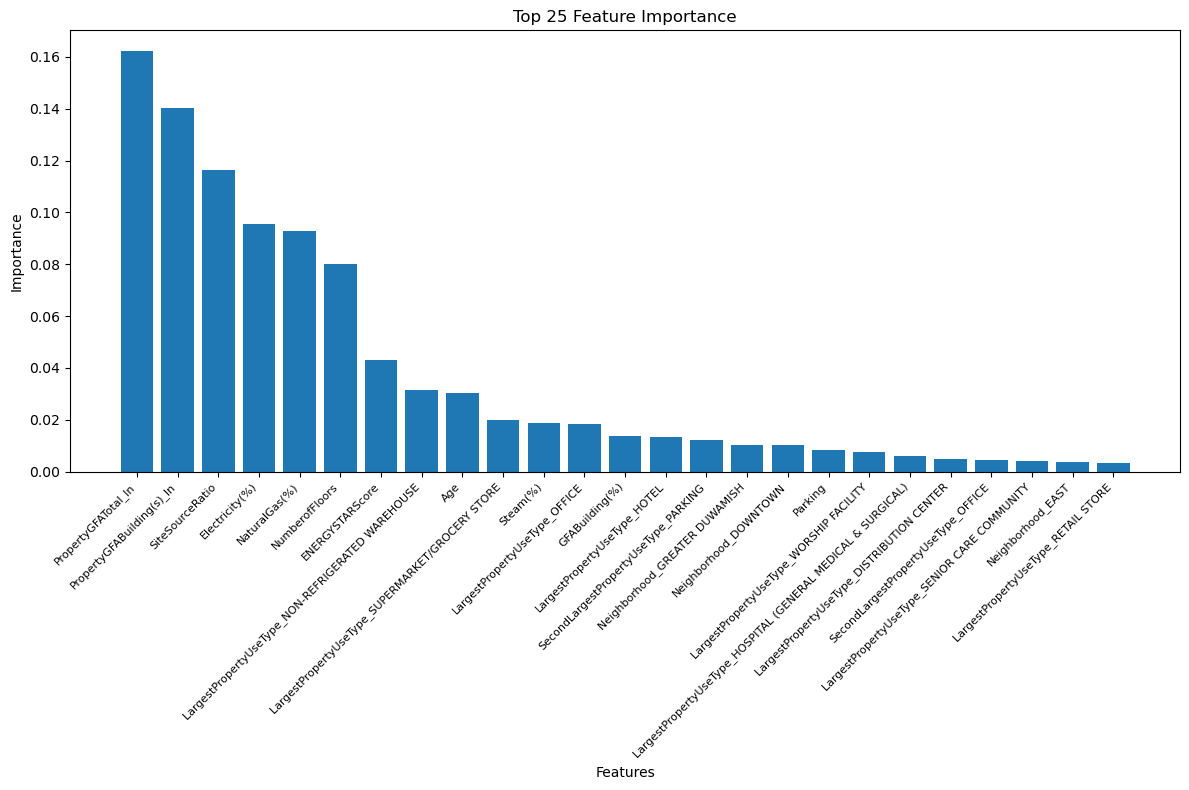

In [59]:
# Get feature importances from the best model
feature_importances = best_rf_model_1.feature_importances_

# Get feature names
feature_names = X_train.columns

# Sort feature importances in descending order
sorted_indices = feature_importances.argsort()[::-1]
sorted_feature_importances = feature_importances[sorted_indices]
sorted_feature_names = feature_names[sorted_indices]

# Select only the top 25 feature importances
top_25_feature_importances = sorted_feature_importances[:25]
top_25_feature_names = sorted_feature_names[:25]

# Plot feature importances
plt.figure(figsize=(12, 8))
plt.bar(range(len(top_25_feature_importances)), top_25_feature_importances, tick_label=top_25_feature_names)
plt.xticks(rotation=45, ha='right', fontsize=8)
plt.xlabel('Features')
plt.ylabel('Importance')
plt.title('Top 25 Feature Importance')
plt.tight_layout()
plt.show()

## No Energy Score, without Outliers

In [60]:
df = pd.read_csv('df_score_noout.csv')
df.set_index('OSEBuildingID', inplace=True)

In [61]:
X_train, X_test, y_train, y_test, target = data_prep(df, target='TotalGHGEmissions_ln', test_size=0.3, random_state=42, scaler_type='robust')

In [62]:
rf_regressor = RandomForestRegressor(random_state=42)
model_name = 'rf_regressor'

rf_regressor.fit(X_train, y_train) # on fit

y_pred = rf_regressor.predict(X_test) 
y_train_pred = rf_regressor.predict(X_train)# on prédit

# Résultats
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)
r_squared = r2_score(y_test, y_pred)
r_squared_train = r2_score(y_train, y_train_pred)

print("Random Forest Regressor Metrics:")
print("Root Mean Squared Error:", rmse)
print("Mean Absolute Error:", mae)
print("R-squared Score:", r_squared)
print("Training Set - R-squared Score:", r_squared_train)

Random Forest Regressor Metrics:
Root Mean Squared Error: 0.5284073191929121
Mean Absolute Error: 0.3806754925415832
R-squared Score: 0.8548770396017212
Training Set - R-squared Score: 0.981903693070904


In [63]:
# Cross Validation 5 folds
cv_scores = cross_val_score(rf_regressor, X_train, y_train, cv=5, scoring='neg_mean_squared_error')

# Conversion des MSE négatives en positives
cv_rmse_scores = np.sqrt(-cv_scores)

# Résultats
print("Cross-Validation RMSE Scores:", cv_rmse_scores)
print("Mean RMSE:", cv_rmse_scores.mean())

Cross-Validation RMSE Scores: [0.45419652 0.53392539 0.44036557 0.42334285 0.57121552]
Mean RMSE: 0.4846091683683548


In [64]:
results = pd.concat([results, pd.DataFrame({'Algo': ['RandomForestRegressor'],
                                            'Model Name': [model_name],
                                            'Outliers': ['Without'],
                                            'EnergyScore': ['With'],
                                            'Target': [target],
                                            'Hyperparams': ['Default'],
                                            'R-squared Train': [r_squared_train],
                                            'R-squared': [r_squared],
                                            'MAE': [mae],
                                            'RMSE': [rmse], 
                                            'CV Mean RMSE': [cv_rmse_scores.mean()],
                                            'Train Rows': [X_train.shape[0]] })], ignore_index=True)

### Random Search pour trouver les meilleurs hyperparamètres

In [65]:
# Parameter Grid
param_dist = {
    'n_estimators': randint(100, 1000),  # Nb d'arbres
    'max_features': ['auto', 'sqrt'],   # Nb de features
    'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, None],  
    'min_samples_split': randint(2, 20),  
    'min_samples_leaf': randint(1, 20),    
    'bootstrap': [True, False]            
}

# on instancie
rf = RandomForestRegressor(random_state=42)
random_search = RandomizedSearchCV(estimator=rf, param_distributions=param_dist, n_iter=100, cv=5, random_state=42, n_jobs=-1)

# on fit
random_search.fit(X_train, y_train)

# Sélection du meilleur modèle
best_rf_model_2 = random_search.best_estimator_
model_name = 'best_rf_model_2'

# On prédit
y_pred = best_rf_model_2.predict(X_test)
y_train_pred = best_rf_model_2.predict(X_train)

# Résultats
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)
r_squared = r2_score(y_test, y_pred)
r_squared_train = r2_score(y_train, y_train_pred)

print("Best Hyperparameters:", random_search.best_params_)
print("Root Mean Squared Error:", rmse)
print("Mean Absolute Error:", mae)
print("R-squared Score:", r_squared)
print("Training Set - R-squared Score:", r_squared_train)


225 fits failed out of a total of 500.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
119 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 732, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\base.py", line 1144, in wrapper
    estimator._validate_params()
  File "C:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\base.py", line 637, in _validate_params
    validate_parameter_constraints(
  File "C:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\utils\_param_validation.py", line 95, in validate_parameter_constraints
    raise InvalidP

Best Hyperparameters: {'bootstrap': True, 'max_depth': 50, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 4, 'n_estimators': 227}
Root Mean Squared Error: 0.5607006297902446
Mean Absolute Error: 0.41676524913283064
R-squared Score: 0.836596796060885
Training Set - R-squared Score: 0.9655930072393311


In [66]:
# Cross Validation 5 folds
cv_scores = cross_val_score(best_rf_model_2, X_train, y_train, cv=5, scoring='neg_mean_squared_error')

# Conversion des MSE négatives en positives
cv_rmse_scores = np.sqrt(-cv_scores)

# Résultats
print("Cross-Validation RMSE Scores:", cv_rmse_scores)
print("Mean RMSE:", cv_rmse_scores.mean())

Cross-Validation RMSE Scores: [0.49005314 0.58433475 0.53936294 0.46455843 0.61450409]
Mean RMSE: 0.538562672473245


In [67]:
results = pd.concat([results, pd.DataFrame({'Algo': ['RandomForestRegressor'],
                                            'Model Name': [model_name],
                                            'Outliers': ['Without'],
                                            'EnergyScore': ['With'],
                                            'Target': [target],
                                            'Hyperparams': [random_search.best_params_],
                                            'R-squared Train': [r_squared_train],
                                            'R-squared': [r_squared],
                                            'MAE': [mae],
                                            'RMSE': [rmse], 
                                            'CV Mean RMSE': [cv_rmse_scores.mean()],
                                            'Train Rows': [X_train.shape[0]] })], ignore_index=True)

### Feature importance

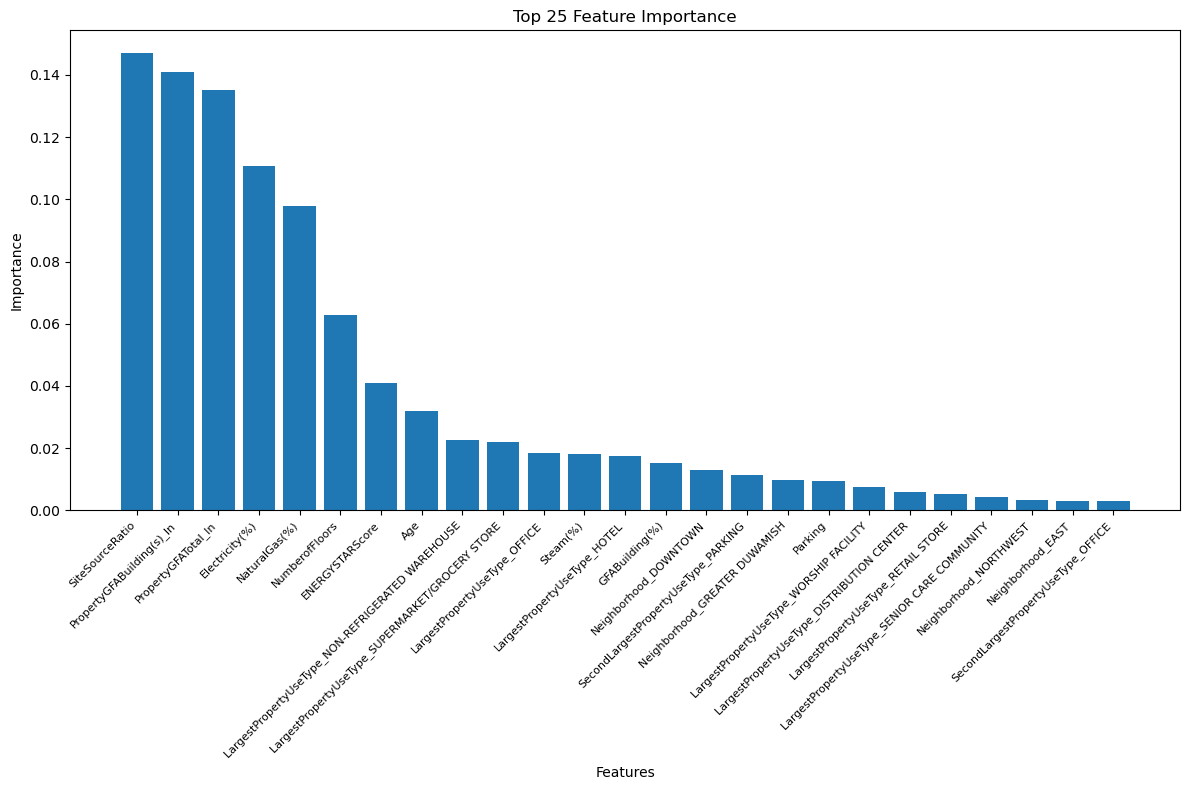

In [68]:
# Get feature importances from the best model
feature_importances = best_rf_model_2.feature_importances_

# Get feature names
feature_names = X_train.columns

# Sort feature importances in descending order
sorted_indices = feature_importances.argsort()[::-1]
sorted_feature_importances = feature_importances[sorted_indices]
sorted_feature_names = feature_names[sorted_indices]

# Select only the top 25 feature importances
top_25_feature_importances = sorted_feature_importances[:25]
top_25_feature_names = sorted_feature_names[:25]

# Plot feature importances
plt.figure(figsize=(12, 8))
plt.bar(range(len(top_25_feature_importances)), top_25_feature_importances, tick_label=top_25_feature_names)
plt.xticks(rotation=45, ha='right', fontsize=8)
plt.xlabel('Features')
plt.ylabel('Importance')
plt.title('Top 25 Feature Importance')
plt.tight_layout()
plt.show()

# 5. XGBoost

In [69]:
from xgboost import XGBRegressor

## No Energy Score, with Outliers

In [70]:
df = pd.read_csv('df_score_out.csv')
df.set_index('OSEBuildingID', inplace=True)

In [71]:
X_train, X_test, y_train, y_test, target = data_prep(df, target='TotalGHGEmissions_ln', test_size=0.3, random_state=42, scaler_type='robust')

In [72]:
xgb_regressor = XGBRegressor(random_state=42)

# Fit
xgb_regressor.fit(X_train, y_train)
model_name = 'xgb_regressor'

# On prédit
y_pred = xgb_regressor.predict(X_test)
y_train_pred = xgb_regressor.predict(X_train)


# Résultats
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r_squared = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r_squared_train = r2_score(y_train, y_train_pred)


print("XGBoost Regressor Metrics:")
print("Mean Squared Error:", mse)
print("Root Mean Squared Error:", rmse)
print("Mean Absolute Error:", mae)
print("R-squared Score:", r_squared)
print("Training Set - R-squared Score:", r_squared_train)

XGBoost Regressor Metrics:
Mean Squared Error: 0.2939354498185479
Root Mean Squared Error: 0.542158140968618
Mean Absolute Error: 0.39102617965202396
R-squared Score: 0.8679037817195099
Training Set - R-squared Score: 0.9994803551954484


In [73]:
# Cross Validation 5 folds
cv_scores = cross_val_score(xgb_regressor, X_train, y_train, cv=5, scoring='neg_mean_squared_error')

# Conversion des MSE négatives en positives
cv_rmse_scores = np.sqrt(-cv_scores)

# Résultats
print("Cross-Validation RMSE Scores:", cv_rmse_scores)
print("Mean RMSE:", cv_rmse_scores.mean())

Cross-Validation RMSE Scores: [0.51988406 0.53131207 0.48986643 0.61498195 0.49348365]
Mean RMSE: 0.5299056317504556


In [74]:
results = pd.concat([results, pd.DataFrame({'Algo': ['XGBRegressor'],
                                            'Model Name': [model_name],
                                            'Outliers': ['With'],
                                            'EnergyScore': ['With'],
                                            'Target': [target],
                                            'Hyperparams': ['Default'],
                                            'R-squared Train': [r_squared_train],
                                            'R-squared': [r_squared],
                                            'MAE': [mae],
                                            'RMSE': [rmse], 
                                            'CV Mean RMSE': [cv_rmse_scores.mean()],
                                            'Train Rows': [X_train.shape[0]] })], ignore_index=True)

### Random Search pour trouver les meilleurs hyperparamètres

In [75]:
# Param Grid
param_dist = {
    'n_estimators': randint(100, 1000),  
    'max_depth': randint(3, 10),          
    'learning_rate': uniform(0.01, 0.4),  
    'subsample': uniform(0.5, 0.5),       
    'colsample_bytree': uniform(0.5, 0.5),
    'gamma': [0, 1, 5],                   
    'reg_alpha': [0, 0.1, 0.5, 1],        
    'reg_lambda': [0, 0.1, 0.5, 1],       
    'random_state': [42]
}



xgb_regressor = XGBRegressor(random_state=42)
random_search = RandomizedSearchCV(estimator=xgb_regressor, param_distributions=param_dist, n_iter=100, cv=5, random_state=42, n_jobs=-1)

# on fit
random_search.fit(X_train, y_train)

# Sélection du meilleur modèle
best_xgb_model_1 = random_search.best_estimator_
model_name = 'best_xgb_model_1'

# On prédit
y_pred = best_xgb_model_1.predict(X_test)
y_train_pred = best_xgb_model_1.predict(X_train)

# Résultats
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)
r_squared = r2_score(y_test, y_pred)
r_squared_train = r2_score(y_train, y_train_pred)

print("Best Hyperparameters:", random_search.best_params_)
print("Root Mean Squared Error:", rmse)
print("Mean Absolute Error:", mae)
print("R-squared Score:", r_squared)
print("Training Set - R-squared Score:", r_squared_train)

Best Hyperparameters: {'colsample_bytree': 0.8442499503826832, 'gamma': 0, 'learning_rate': 0.07931772802833831, 'max_depth': 3, 'n_estimators': 850, 'random_state': 42, 'reg_alpha': 0.1, 'reg_lambda': 1, 'subsample': 0.7746133323530602}
Root Mean Squared Error: 0.44122451275919033
Mean Absolute Error: 0.3127976842418309
R-squared Score: 0.912510147964913
Training Set - R-squared Score: 0.9973838183060831


In [76]:
# Cross Validation 5 folds
cv_scores = cross_val_score(best_xgb_model_1, X_train, y_train, cv=5, scoring='neg_mean_squared_error')

# Conversion des MSE négatives en positives
cv_rmse_scores = np.sqrt(-cv_scores)

# Résultats
print("Cross-Validation RMSE Scores:", cv_rmse_scores)
print("Mean RMSE:", cv_rmse_scores.mean())

Cross-Validation RMSE Scores: [0.4233381  0.47371857 0.38540167 0.50049385 0.38682185]
Mean RMSE: 0.43395480859276747


In [77]:
results = pd.concat([results, pd.DataFrame({'Algo': ['XGBRegressor'],
                                            'Model Name': [model_name],
                                            'Outliers': ['With'],
                                            'EnergyScore': ['With'],
                                            'Target': [target],
                                            'Hyperparams': [random_search.best_params_],
                                            'R-squared Train': [r_squared_train],
                                            'R-squared': [r_squared],
                                            'MAE': [mae],
                                            'RMSE': [rmse], 
                                            'CV Mean RMSE': [cv_rmse_scores.mean()],
                                            'Train Rows': [X_train.shape[0]] })], ignore_index=True)

## No Energy Score, without Outliers

In [78]:
df = pd.read_csv('df_score_noout.csv')
df.set_index('OSEBuildingID', inplace=True)

In [79]:
X_train, X_test, y_train, y_test, target = data_prep(df, target='TotalGHGEmissions_ln', test_size=0.3, random_state=42, scaler_type='robust')

In [80]:
xgb_regressor = XGBRegressor(random_state=42)
model_name = 'xgb_regressor'

# Fit
xgb_regressor.fit(X_train, y_train)

# On prédit
y_pred = xgb_regressor.predict(X_test)
y_train_pred = xgb_regressor.predict(X_train)


# Résultats
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r_squared = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r_squared_train = r2_score(y_train, y_train_pred)

# Print evaluation metrics
print("XGBoost Regressor Metrics:")
print("Mean Squared Error:", mse)
print("Root Mean Squared Error:", rmse)
print("Mean Absolute Error:", mae)
print("R-squared Score:", r_squared)
print("Training Set - R-squared Score:", r_squared_train)

XGBoost Regressor Metrics:
Mean Squared Error: 0.23397891001691132
Root Mean Squared Error: 0.483713665319589
Mean Absolute Error: 0.35806948513967873
R-squared Score: 0.8783883465018957
Training Set - R-squared Score: 0.9995293336275208


In [81]:
# Cross Validation 5 folds
cv_scores = cross_val_score(xgb_regressor, X_train, y_train, cv=5, scoring='neg_mean_squared_error')

# Conversion des MSE négatives en positives
cv_rmse_scores = np.sqrt(-cv_scores)

# Résultats
print("Cross-Validation RMSE Scores:", cv_rmse_scores)
print("Mean RMSE:", cv_rmse_scores.mean())

Cross-Validation RMSE Scores: [0.46066635 0.55149429 0.44734846 0.42700318 0.5287749 ]
Mean RMSE: 0.48305743630901093


In [82]:
results = pd.concat([results, pd.DataFrame({'Algo': ['XGBRegressor'],
                                            'Model Name': [model_name],
                                            'Outliers': ['Without'],
                                            'EnergyScore': ['With'],
                                            'Target': [target],
                                            'Hyperparams': ['Default'],
                                            'R-squared Train': [r_squared_train],
                                            'R-squared': [r_squared],
                                            'MAE': [mae],
                                            'RMSE': [rmse], 
                                            'CV Mean RMSE': [cv_rmse_scores.mean()],
                                            'Train Rows': [X_train.shape[0]] })], ignore_index=True)

### Random Search pour trouver les meilleurs hyperparamètres

In [83]:
# Param Grid
param_dist = {
    'n_estimators': randint(100, 1000),  
    'max_depth': randint(3, 10),          
    'learning_rate': uniform(0.01, 0.4),  
    'subsample': uniform(0.5, 0.5),       
    'colsample_bytree': uniform(0.5, 0.5),
    'gamma': [0, 1, 5],                   
    'reg_alpha': [0, 0.1, 0.5, 1],        
    'reg_lambda': [0, 0.1, 0.5, 1],       
    'random_state': [42]
}



xgb_regressor = XGBRegressor(random_state=42)
random_search = RandomizedSearchCV(estimator=xgb_regressor, param_distributions=param_dist, n_iter=100, cv=5, random_state=42, n_jobs=-1)

# on fit
random_search.fit(X_train, y_train)

# Sélection du meilleur modèle
best_xgb_model_2 = random_search.best_estimator_
model_name = 'best_xgb_model_2'

# On prédit
y_pred = best_xgb_model_2.predict(X_test)
y_train_pred = best_xgb_model_2.predict(X_train)

# Résultats
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)
r_squared = r2_score(y_test, y_pred)
r_squared_train = r2_score(y_train, y_train_pred)

print("Best Hyperparameters:", random_search.best_params_)
print("Root Mean Squared Error:", rmse)
print("Mean Absolute Error:", mae)
print("R-squared Score:", r_squared)
print("Training Set - R-squared Score:", r_squared_train)

Best Hyperparameters: {'colsample_bytree': 0.8442499503826832, 'gamma': 0, 'learning_rate': 0.07931772802833831, 'max_depth': 3, 'n_estimators': 850, 'random_state': 42, 'reg_alpha': 0.1, 'reg_lambda': 1, 'subsample': 0.7746133323530602}
Root Mean Squared Error: 0.4014056073861743
Mean Absolute Error: 0.3002183790755233
R-squared Score: 0.916253753720571
Training Set - R-squared Score: 0.9979863125830567


In [84]:
# Cross Validation 5 folds
cv_scores = cross_val_score(best_xgb_model_2, X_train, y_train, cv=5, scoring='neg_mean_squared_error')

# Conversion des MSE négatives en positives
cv_rmse_scores = np.sqrt(-cv_scores)

# Résultats
print("Cross-Validation RMSE Scores:", cv_rmse_scores)
print("Mean RMSE:", cv_rmse_scores.mean())

Cross-Validation RMSE Scores: [0.34248828 0.40181959 0.38223928 0.30883282 0.43900078]
Mean RMSE: 0.37487614835075717


In [85]:
results = pd.concat([results, pd.DataFrame({'Algo': ['XGBRegressor'],
                                            'Model Name': [model_name],
                                            'Outliers': ['Without'],
                                            'EnergyScore': ['With'],
                                            'Target': [target],
                                            'Hyperparams': [random_search.best_params_],
                                            'R-squared Train': [r_squared_train],
                                            'R-squared': [r_squared],
                                            'MAE': [mae],
                                            'RMSE': [rmse], 
                                            'CV Mean RMSE': [cv_rmse_scores.mean()],
                                            'Train Rows': [X_train.shape[0]] })], ignore_index=True)

# Résultats

In [86]:
pd.options.display.float_format = '{:.2f}'.format

In [87]:
results = results.round(2)

In [88]:
# Calcul de la RMSE normalisée
normRMSE_values = results['RMSE'] / (df['TotalGHGEmissions_ln'].max() - df['TotalGHGEmissions_ln'].min())
normRMSE_name = 'Normalized RMSE' 

# insertion à l'avant dernière position
insert_position = len(results.columns) - 1
results.insert(insert_position, normRMSE_name, normRMSE_values)

In [89]:
display(results)

,Algo,Model Name,Outliers,EnergyScore,Target,Hyperparams,R-squared Train,R-squared,MAE,RMSE,CV Mean RMSE,Normalized RMSE,Train Rows
0,DummyRegressor,dummy_regressor,With,With,TotalGHGEmissions_ln,Mean,0.00,-0.00,1.20,1.49,NaN,0.17,642
1,DummyRegressor,dummy_regressor,Without,With,TotalGHGEmissions_ln,Mean,0.00,-0.02,1.12,1.40,NaN,0.16,616
2,LinearRegression,linreg_model,With,With,TotalGHGEmissions_ln,Nan,0.95,0.83,0.33,0.61,0.45,0.07,642
3,Elastic Net,best_model_EN_1,With,With,TotalGHGEmissions_ln,"{'alpha': 0.1, 'l1_ratio': 0.3}",0.74,0.73,0.61,0.78,0.82,0.09,642
4,LinearRegression,linreg_model,Without,With,TotalGHGEmissions_ln,Nan,0.94,0.91,0.29,0.42,0.40,0.05,616
5,Elastic Net,best_model_EN_2,Without,With,TotalGHGEmissions_ln,"{'alpha': 0.1, 'l1_ratio': 0.1}",0.78,0.79,0.50,0.64,0.70,0.07,616
6,KNeighborsRegression,best_knn_model_1,With,With,TotalGHGEmissions_ln,"{'algorithm': 'auto', 'n_neighbors': 10, 'weig...",1.00,0.58,0.74,0.97,1.01,0.11,642
7,KNeighborsRegression,best_knn_model_2,Without,With,TotalGHGEmissions_ln,"{'algorithm': 'auto', 'n_neighbors': 10, 'weig...",1.00,0.53,0.74,0.96,0.92,0.11,616
8,RandomForestRegressor,rf_regressor,With,With,TotalGHGEmissions_ln,Default,0.98,0.85,0.41,0.58,0.56,0.07,642
9,RandomForestRegressor,best_rf_model_1,With,With,TotalGHGEmissions_ln,"{'bootstrap': True, 'max_depth': 50, 'max_feat...",0.96,0.84,0.42,0.59,0.60,0.07,642


# Sélection du meilleur modèle

Le meilleur modèle semble être best_xgb_model_2 (plus haut r^2, plus basse rmse), appliqué sur le dataframe ne contenant pas les outliers. Creusons les résultats de ce modèle.

In [91]:
df = pd.read_csv('df_score_noout.csv')
df.set_index('OSEBuildingID', inplace=True)

In [92]:
X_train, X_test, y_train, y_test, target = data_prep(df, target='TotalGHGEmissions_ln', test_size=0.3, random_state=42, scaler_type='robust')

In [93]:
# Fit
best_xgb_model_2.fit(X_train, y_train)

# On prédit
y_pred = best_xgb_model_2.predict(X_test)
y_train_pred = best_xgb_model_2.predict(X_train)


# Résultats
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r_squared = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r_squared_train = r2_score(y_train, y_train_pred)

print("Best XGBoost Regressor Metrics:")
print("Mean Squared Error:", mse.round(3))
print("Root Mean Squared Error:", rmse.round(3))
print("Mean Absolute Error:", mae.round(3))
print("R-squared Score:", r_squared.round(3))
print("Training Set - R-squared Score:", r_squared_train.round(3))

Best XGBoost Regressor Metrics:
Mean Squared Error: 0.161
Root Mean Squared Error: 0.401
Mean Absolute Error: 0.3
R-squared Score: 0.916
Training Set - R-squared Score: 0.998


### Feature Importance - SHAP

In [94]:
explainer = shap.Explainer(best_xgb_model_2)
shap_values = explainer.shap_values(X_test)

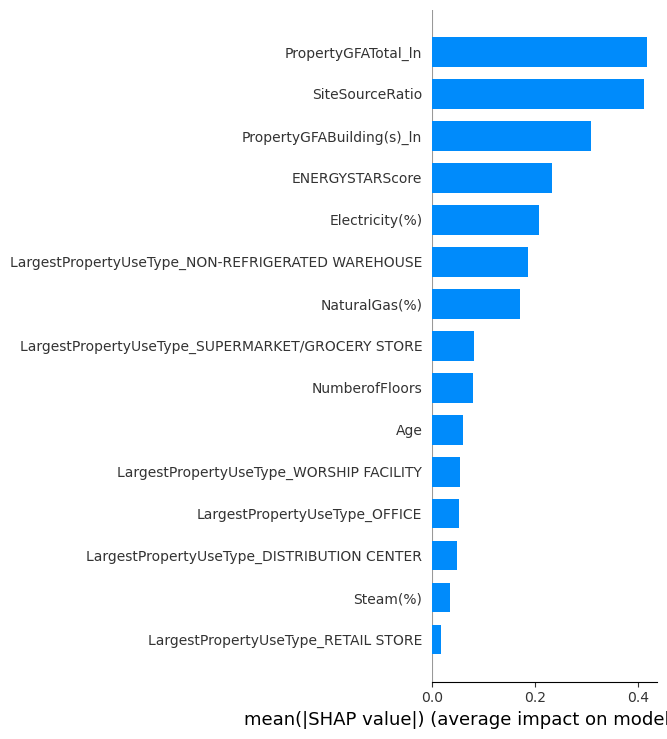

In [95]:
# Plot 
shap.summary_plot(shap_values, X_test, max_display=15, plot_type="bar", show=False)
plt.xticks(fontsize=10) 
plt.yticks(fontsize=10) 
plt.show()

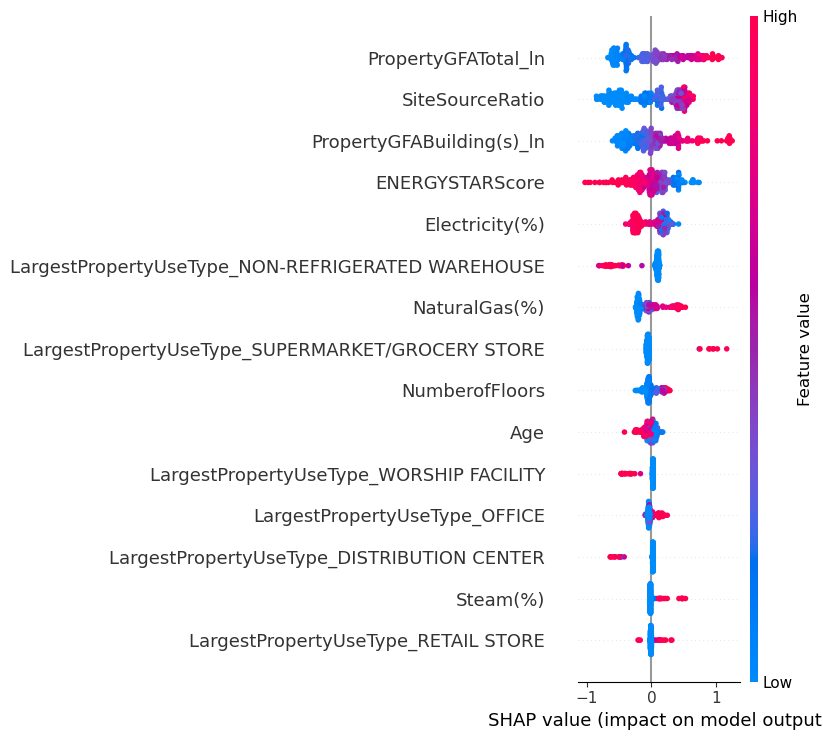

In [96]:
shap.summary_plot(shap_values, X_test, max_display=15)

### Feature Importance - LIME

In [97]:
explainer = lime.lime_tabular.LimeTabularExplainer(X_train.values, feature_names=X_train.columns, mode='regression')

# Choisir un indice pour afficher le détail du calcul de la prédiction de la ligne
instance_index = 56
instance = X_test.iloc[[instance_index]]

# Calcul de l'explication
explanation = explainer.explain_instance(instance.values[0], best_xgb_model_2.predict, num_features=len(X_test.columns))

# Display
explanation.show_in_notebook()